## interplay between nucleosome repair/reassembly, eviction, and transcription
### nicole pagane | roberts lab

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
from mpl_toolkits import mplot3d
from matplotlib.colors import LogNorm

%matplotlib inline

pass

In [374]:
# declare universal constants
NUC_SPACE = 45 
OCT_LEN =  126 #147
HEX_LEN = 107*OCT_LEN/147
NUC_UNWRAP = 40
LOOP_OCT = 100*OCT_LEN/147
LOOP_HEX = 71*OCT_LEN/147
NUC_MOVE_OCT = 72
NUC_MOVE_HEX = NUC_MOVE_OCT*LOOP_HEX/LOOP_OCT
NUC_DENS = 0.9
MIN_RATE = 750
MAX_RATE = 7500

print HEX_LEN, LOOP_OCT, LOOP_HEX, NUC_MOVE_OCT, NUC_MOVE_HEX

91 85 60 72 50


In [3]:
# initialize system without further knowledge of isw2 and isw1a mechanisms
# this is derived from results of statistical positioning

# intialize gene
def initializeGene(nucLen = OCT_LEN, geneLen = 2000, linker = NUC_SPACE, density = NUC_DENS):
    gene = np.zeros(geneLen)
    # check the density 
    N = int(np.round(density*geneLen/(nucLen + linker)))
    ind = 0
    nucNum = 1
    while ind + nucLen < geneLen and nucNum < N+1:
        gene[ind:ind+nucLen] = nucNum
        spc = linker
        ind = ind + nucLen + spc
        nucNum += 1
    return gene

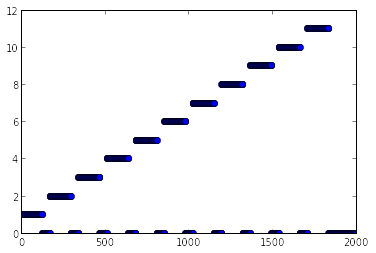

In [4]:
gene = initializeGene()
plt.plot(gene, 'o')
plt.show()

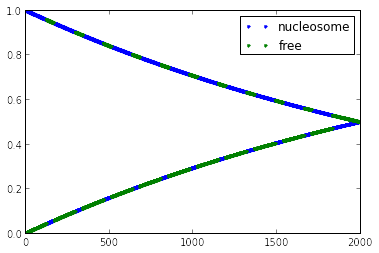

In [5]:
# define gene occupancy expectation
def geneOccupancy(g):
    x = np.linspace(1, len(g), len(g))
    k = -np.log(0.5)
    y = np.exp(-k*x/len(g))
    gScale = np.ceil(g/max(g))*y
    for i in range(len(g)):
        if gScale[i] == 0:
            gScale[i] = 1-y[i]
    return gScale


gRef = geneOccupancy(initializeGene())
plt.plot(gRef, '.', label='nucleosome')
plt.plot(1-gRef, '.', label='free')
plt.legend()
plt.show()

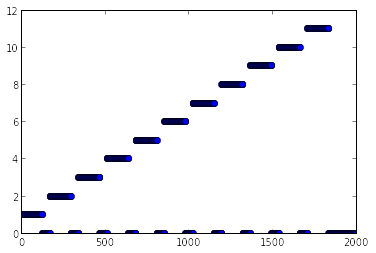

{0.0: 0, 1.0: 45, 2.0: 45, 3.0: 45, 4.0: 45, 5.0: 45, 6.0: 45, 7.0: 45, 8.0: 45, 9.0: 45, 10.0: 45, 11.0: 165}


In [6]:
# determine spacing
def detSpace(g):
    gene = np.linspace(0, len(g)-1, len(g))
    space = {}
    nucs = np.unique(g)
    for i in range(1,len(nucs)):
        lowBound = np.asarray(gene[g==nucs[i-1]], int)
        if nucs[i-1] == 0: lowBound = [-1];
        space[nucs[i-1]] = np.asarray(gene[g==nucs[i]], int)[0] - lowBound[-1] - 1
    # append last nuc spacing to end of gene
    space[nucs[-1]] = len(g) - np.asarray(gene[g==nucs[-1]], int)[-1]
    return space

plt.plot(gene, 'o')
plt.show()
print detSpace(gene)

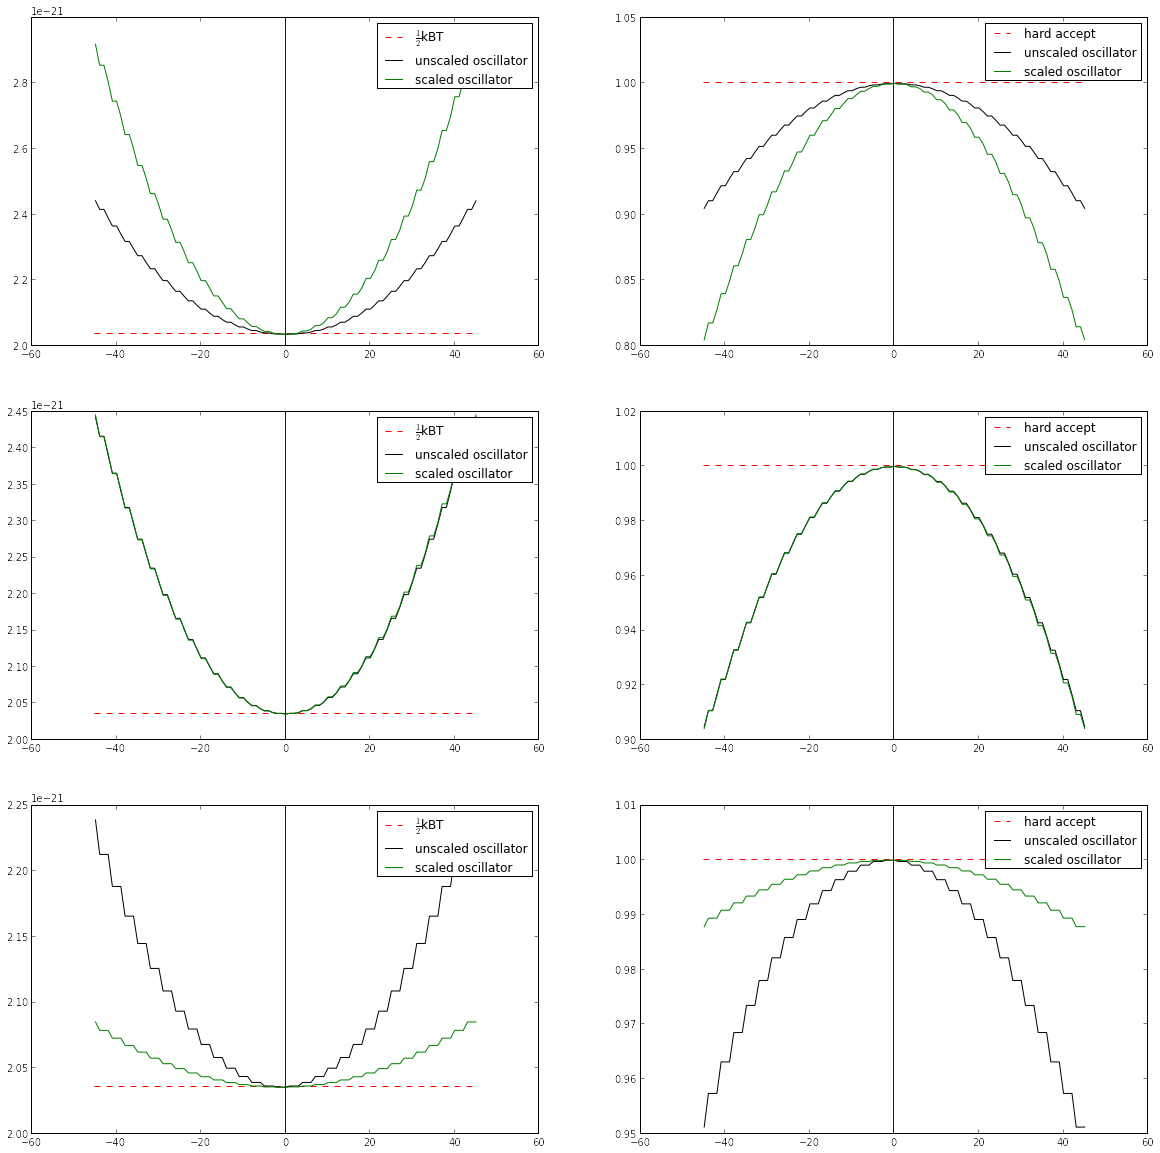

In [270]:
kB = 1.38e-23; T = 295.0
ecoeff = 1.0/2
kspring = ecoeff*2*kB*T/(1.0*(NUC_SPACE)/3*1e-9)**2
kexpScale = -np.log(0.05)

fig = plt.figure(figsize=(20,20))
g0 = initializeGene()
nucs = [2, int(max(g0)/2), max(g0)]
ind = 1
for t in nucs:
    nuc = np.asarray(np.linspace(0, len(g0)-1, len(g0))[g0==t], int)
    eSum = []
    noSum = []
    aVec = np.asarray(np.linspace(-NUC_SPACE, NUC_SPACE, 2*NUC_SPACE+1), int)
    for i in aVec:
        g = np.zeros(len(g0)) + g0
        g[nuc] = 0
        g[nuc + i] = t
        dspc = detSpace(g); kspc = dspc.keys(); spcSort = np.argsort(kspc); kspc = np.asarray(kspc)[spcSort]
        spc = dspc.values(); spc = np.asarray(spc)[spcSort]
        spc = spc[1:len(spc)-1]; kspc = kspc[1:len(kspc)-1] # remove the pre +1 linker and remaining space
        en = 0.5*kspring*((NUC_SPACE - spc)/3*1e-9)**2 + ecoeff*kB*T
        noSum.append(1.0*np.sum(en)/len(spc))
        cNuc = []
        for j in kspc:
            cNuc.append(np.median(np.asarray(np.linspace(0, len(g0)-1, len(g0))[g0==j], int)))
        deg = np.exp(-kexpScale*np.asarray(cNuc)/len(g))
        en *= deg
        eSum.append(np.sum(en)/np.sum(deg))
    ax = fig.add_subplot(3,2,ind)
    ax.plot(aVec, np.ones(len(aVec))*ecoeff*kB*T, 'r--', label = r'$\frac{1}{2}$kBT')
    ax.plot(aVec, noSum, 'k', label = 'unscaled oscillator')
    ax.plot(aVec, eSum, 'g', label = 'scaled oscillator')
    ax.axvline(0)
    plt.legend()
    ax = fig.add_subplot(3,2,ind+1)
    ax.plot(aVec, np.ones(len(aVec))*1.0001, 'r--', label = 'hard accept')
    ax.plot(aVec, np.exp(-(np.asarray(noSum) - ecoeff*kB*T)/(kB*T)), 'k', label = 'unscaled oscillator')
    ax.plot(aVec, np.exp(-(np.asarray(eSum) - ecoeff*kB*T)/(kB*T)), 'g', label = 'scaled oscillator')
    ax.axvline(0)
    plt.legend()
    ind += 2

plt.show()

In [400]:
# define energy calculation
def energy(g):
    dspc = detSpace(g); kspc = dspc.keys(); spcSort = np.argsort(kspc); kspc = np.asarray(kspc)[spcSort]
    spc = dspc.values(); spc = np.asarray(spc)[spcSort]
    spc = spc[1:len(spc)-1]; kspc = kspc[1:len(kspc)-1] # remove the pre +1 linker and remaining space
    if len(spc) == 0: return 0 
    en = 0.5*kspring*((NUC_SPACE - spc)/3*1e-9)**2 + ecoeff*kB*T
    cNuc = []
    for j in kspc:
        cNuc.append(np.median(np.asarray(np.linspace(0, len(g)-1, len(g))[g==j], int)))
    deg = np.exp(-kexpScale*np.asarray(cNuc)/len(g))
    en *= deg
    return np.sum(en)/np.sum(deg)

In [401]:
# MCMC to simulate nucleosome shuffling
def MCMC(g = initializeGene(), N = 1000):
    N = int(N)
    curE = energy(g); lowE = curE
    eVec = []
    propG = np.zeros(len(g))
    gSum = np.ceil(g/max(g))
    gState = np.zeros(len(g)); gState = g[:]*1.0 # shallow copy
    # check that there is more than one nuc left
    if len(set(g)) <= 2:
        return gState, eVec, gSum # quit since dynamics of one nucleosome is not interesting
    nucs = np.unique(g)
    # determine density of gene
    nucN = np.round(NUC_DENS*len(g)/(OCT_LEN + NUC_SPACE))
    for i in range(N):
        # select random nucleosome
        propNuc = nucs[np.random.randint(2, len(nucs))] # dont select +1 nuc
        propInd = np.array(np.linspace(0, len(g)-1, len(g))[g == propNuc], int) 
        # select random movement
        propMove = int(np.random.normal(0, propNuc*(nucN/(len(nucs)-1))*(NUC_SPACE))) # sample from normal w spread nuc len
        # implement proposed movement
        move = propInd + propMove
        moveTrim = move[move >= 0]
        move = moveTrim[moveTrim < len(g)]
        # check for collision
        propG = g[:]*1.0 # shallow copy
        propG[propInd] = 0
        if (np.sum(propG[move]) == 0 and len(move) == len(propInd)):
            propG[move] = propNuc
            # metropolis criterion
            propE = energy(propG)
            delE = propE - curE
            rand = np.random.rand()
            if (rand < np.exp(-delE/(kB*T))):
                # accept change
                g = propG[:]*1.0 #shallow copy
                curE = propE
            #if (i >= 1.0*N/2): # reject the first half off the simulation
            gSum += np.ceil(g/max(g))
            eVec.append(curE)
            # save lowest energy config
            if propE < lowE:
                gState = g[:]*1.0
                lowE = propE
    return gState, eVec, gSum

In [402]:
ltest = int(0.5*NUC_SPACE)
dens = 0.5
gene = initializeGene(linker = ltest, density = dens)

n1 = MIN_RATE; n2 = 3000; n3 = MAX_RATE

gene1, eVec1, gA1= MCMC(gene, n1)
gene2, eVec2, gA2 = MCMC(gene, n2)
gene3, eVec3, gA3 = MCMC(gene, n3)

acecptance rate for 1: 0.234666666667
acecptance rate for 2: 0.365
acecptance rate for 3: 0.3624


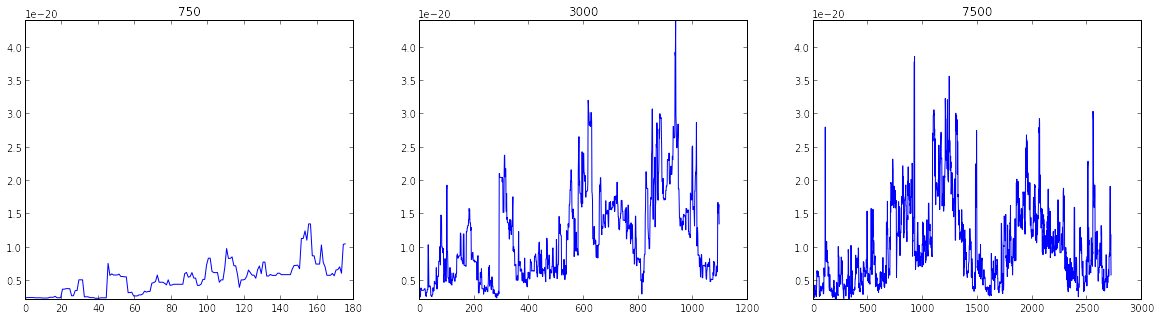

In [403]:
print 'acecptance rate for 1: ' + str(1.0*len(eVec1)/(n1))
print 'acecptance rate for 2: ' + str(1.0*len(eVec2)/(n2))
print 'acecptance rate for 3: ' + str(1.0*len(eVec3)/(n3))

totE = []; totE.extend(eVec1); totE.extend(eVec2); totE.extend(eVec3)

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_ylim([min(totE), max(totE)])
ax.set_title(n1)
ax.plot(eVec1)
ax = fig.add_subplot(1,3,2)
ax.set_ylim([min(totE), max(totE)])
ax.set_title(n2)
ax.plot(eVec2)
ax = fig.add_subplot(1,3,3)
ax.set_ylim([min(totE), max(totE)])
ax.set_title(n3)
ax.plot(eVec3)

plt.show()

intial energy  2.47878666667e-21


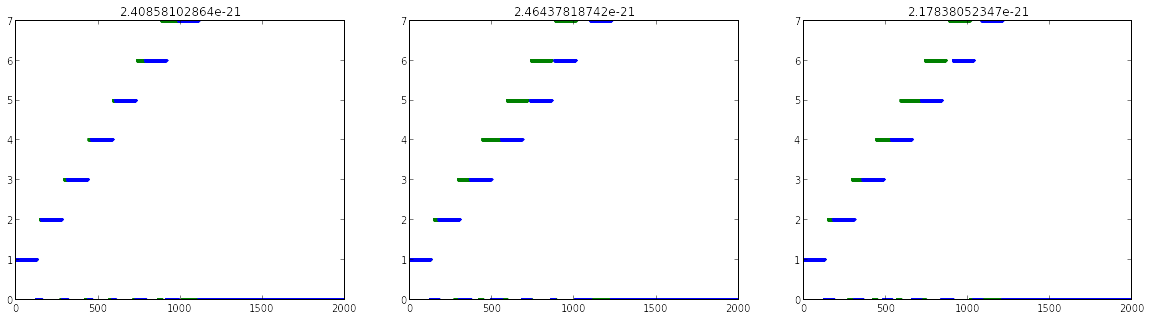

In [404]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_title(n1)
ax.plot(gene, 'g.')
ax.plot(gene1, 'b.')
ax.set_title(energy(gene1))
ax = fig.add_subplot(1,3,2)
ax.set_title(n2)
ax.plot(gene, 'g.')
ax.plot(gene2, 'b.')
ax.set_title(energy(gene2))
ax = fig.add_subplot(1,3,3)
ax.set_title(n3)
ax.plot(gene, 'g.')
ax.plot(gene3, 'b.')
ax.set_title(energy(gene3))

print 'intial energy ', energy(gene)

plt.show()

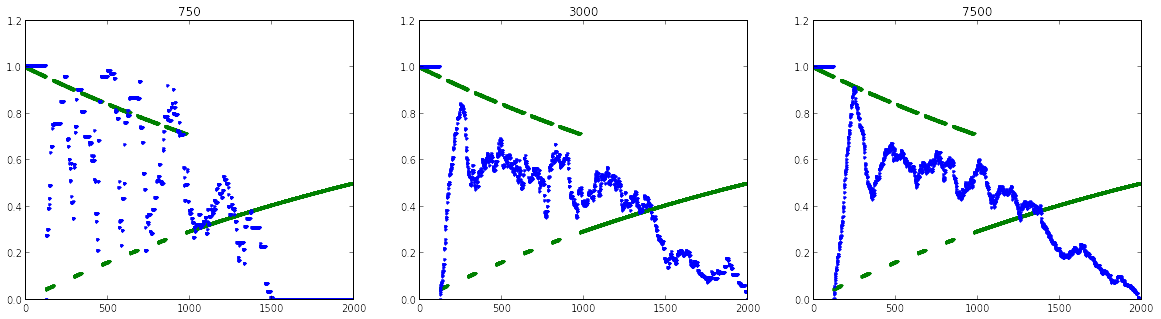

In [405]:
# reference
gRef = geneOccupancy(initializeGene(density = dens))

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_title(n1)
ax.plot(gRef, 'g.')
ax.plot(gA1/len(eVec1), 'b.')
ax = fig.add_subplot(1,3,2)
ax.set_title(n2)
ax.plot(gRef, 'g.')
ax.plot(gA2/len(eVec2), 'b.')
ax = fig.add_subplot(1,3,3)
ax.set_title(n3)
ax.plot(gRef, 'g.')
ax.plot(gA3/len(eVec3), 'b.')

plt.show()

### add transcription

In [383]:
# probs from paper 
kue = 1; N = 40; Nt = 147; kt = 0.02; kd = 0.027
phex = (kue/(kt+kue))**N * ((kd/(kt+kd)) + (kt/(kt+kd)) * (kue/(kt+kue+kd))**(Nt-N)) - (kue/(kt+kue))**Nt
poct = 1.0 - (kue/(kt+kue))**N * ((kd/(kt+kd)) + (kt/(kt+kd)) * (kue/(kt+kue+kd))**(Nt-N))
pfree = (kue/(kt+kue))**Nt

print 'prob of hex: ', phex*100 
print 'prob of oct: ', poct*100
print 'prob of free: ', pfree*100

prob of hex:  20.7163647036
prob of oct:  73.8414321259
prob of free:  5.44220317046


In [384]:
# define RNAP passage effects
def RNAP(g):
    # check that there is more than one nuc left
    if len(set(g)) <= 2:
        return g # quit since dynamics of one nucleosome is not interesting
    temp = np.zeros(len(g))
    spc = detSpace(g)
    nucs = np.sort(spc.keys())
    # attempt movement on the post +1 nucleosomes
    i = 1
    while (i < len(spc)-1):
        nuc = np.asarray(np.linspace(0, len(g)-1, len(g))[g==nucs[i+1]], dtype = int)
        if (spc[nucs[i]] + NUC_UNWRAP >= LOOP_OCT and len(g[nuc]) == OCT_LEN): # octosome
            # randomly determine fate of octomer from above probabilities
            rand = np.random.random()
            if rand < pfree: # remove octomer
                g[nuc] = 0 
            elif rand < (pfree+phex): # lose dimer and move upstream
                g[nuc] = 0 
                # shave off sides
                side = (OCT_LEN-HEX_LEN)/2
                nuc = np.asarray(np.linspace(min(nuc)+side, max(nuc)-side, HEX_LEN), dtype = int)
                add = NUC_UNWRAP
                if spc[nucs[i]] > NUC_MOVE_HEX: add = 0
                g[np.asarray(nuc - NUC_MOVE_HEX + add, int)] = int(nucs[i+1]) 
            else: # move upstream as octomer
                g[nuc] = 0 
                add = NUC_UNWRAP
                if spc[nucs[i]] > NUC_MOVE_OCT: add = 0
                g[np.asarray(nuc - NUC_MOVE_OCT + add, int)] = int(nucs[i+1])
        elif (spc[nucs[i]] + NUC_UNWRAP >= LOOP_HEX and len(g[nuc]) == HEX_LEN): # hexasome
             # randomly determine fate of octomer from above probabilities
                rand = np.random.random()
                if rand < pfree/(pfree+phex): # remove hexasome (reweighted probs)
                    g[nuc] = 0 
                else: # move hexasome
                    g[nuc] = 0 
                    add = NUC_UNWRAP
                    if spc[nucs[i]] > NUC_MOVE_HEX: add = 0
                    g[np.asarray(nuc - NUC_MOVE_HEX + add, int)] = int(nucs[i+1])
        else: # remove nucleosome due to crowding or make hexasome
            g[nuc] = 0
        i += 1
        spc = detSpace(g)
        nucs = np.sort(spc.keys())
    return g

In [406]:
cycles = 10
gene = []
en = []
g = initializeGene();
gAv = []
for i in range(cycles):
    g = RNAP(g)
    en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    gempty = np.sum(g == 0)
    if gempty == (len(g) - OCT_LEN):
        print 'terminated early since only one left'
        en.extend([energy(g)]*(2*(cycles - (i + 1))+1)); gAv.extend([np.ceil(g/max(g))]*(2*(cycles - (i + 1))+1))
        break
    print 'trans ', i+1, ': ', detSpace(g).values()
    g, e, gA = MCMC(g, MAX_RATE)
    en.extend(e); gAv.append(gA/len(e))
    print 'relax ', i+1, ': ', detSpace(g).values()

trans  1 :  [0, 13, 5, 45, 84, 40, 45, 45, 84, 40, 84, 232]
relax  1 :  [0, 49, 48, 47, 75, 18, 42, 66, 74, 16, 102, 180]
trans  2 :  [0, 17, 8, 47, 257, 234, 24, 34, 84, 230]
relax  2 :  [0, 10, 64, 61, 56, 22, 36, 144, 39, 503]
trans  3 :  [0, 200, 29, 16, 61, 53, 122, 61, 553]
relax  3 :  [0, 23, 33, 76, 29, 64, 91, 12, 767]
trans  4 :  [0, 182, 4, 51, 64, 108, 29, 817]
relax  4 :  [0, 29, 82, 49, 9, 96, 97, 893]
trans  5 :  [0, 237, 39, 207, 47, 943]
relax  5 :  [0, 34, 55, 68, 55, 1261]
trans  6 :  [0, 215, 1261, 215]
relax  6 :  [0, 42, 1608, 41]
trans  7 :  [0, 32, 1658, 1]
relax  7 :  [0, 41, 1610, 40]
trans  8 :  [0, 31, 1620, 40]
relax  8 :  [0, 39, 1607, 45]
trans  9 :  [0, 29, 1657, 5]
relax  9 :  [0, 45, 1600, 46]
trans  10 :  [0, 35, 1650, 6]
relax  10 :  [0, 44, 1604, 43]


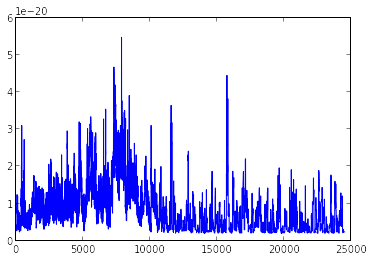

In [407]:
plt.plot(en)
plt.show()

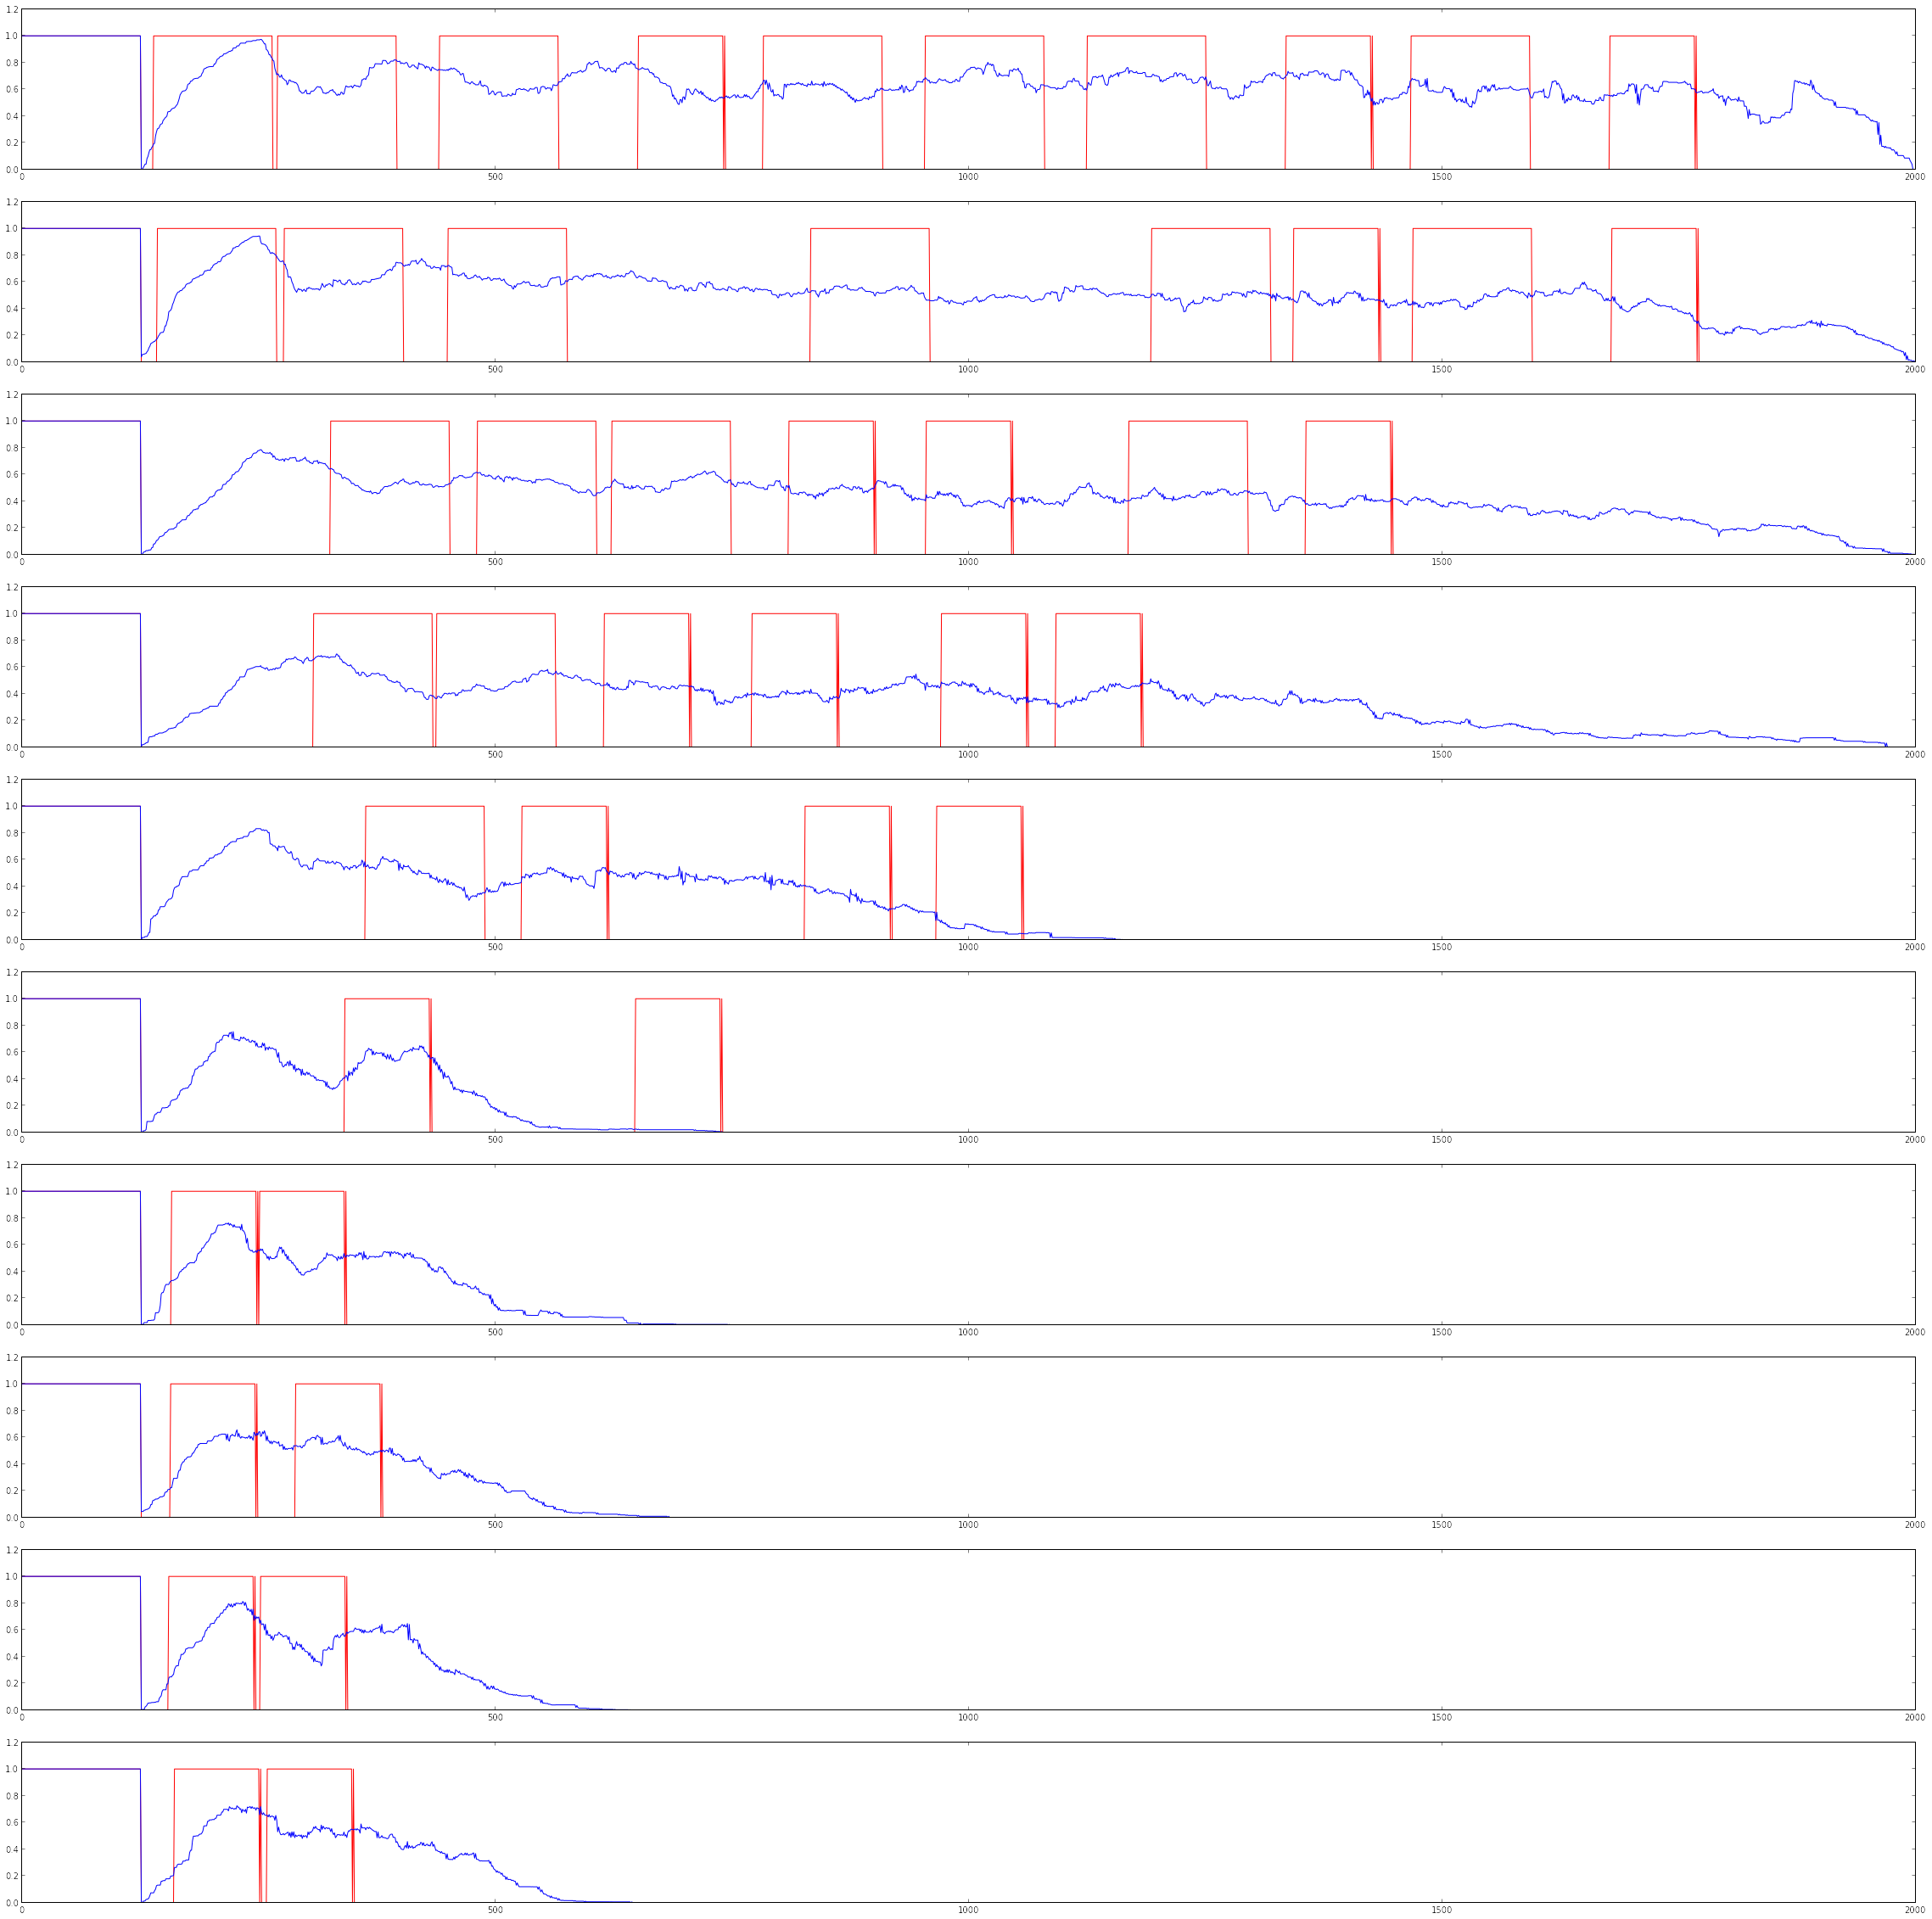

In [408]:
fig = plt.figure(figsize=(4*cycles, 4*cycles))
ind = 0; pltInd = 0
while ind < 2*cycles:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()

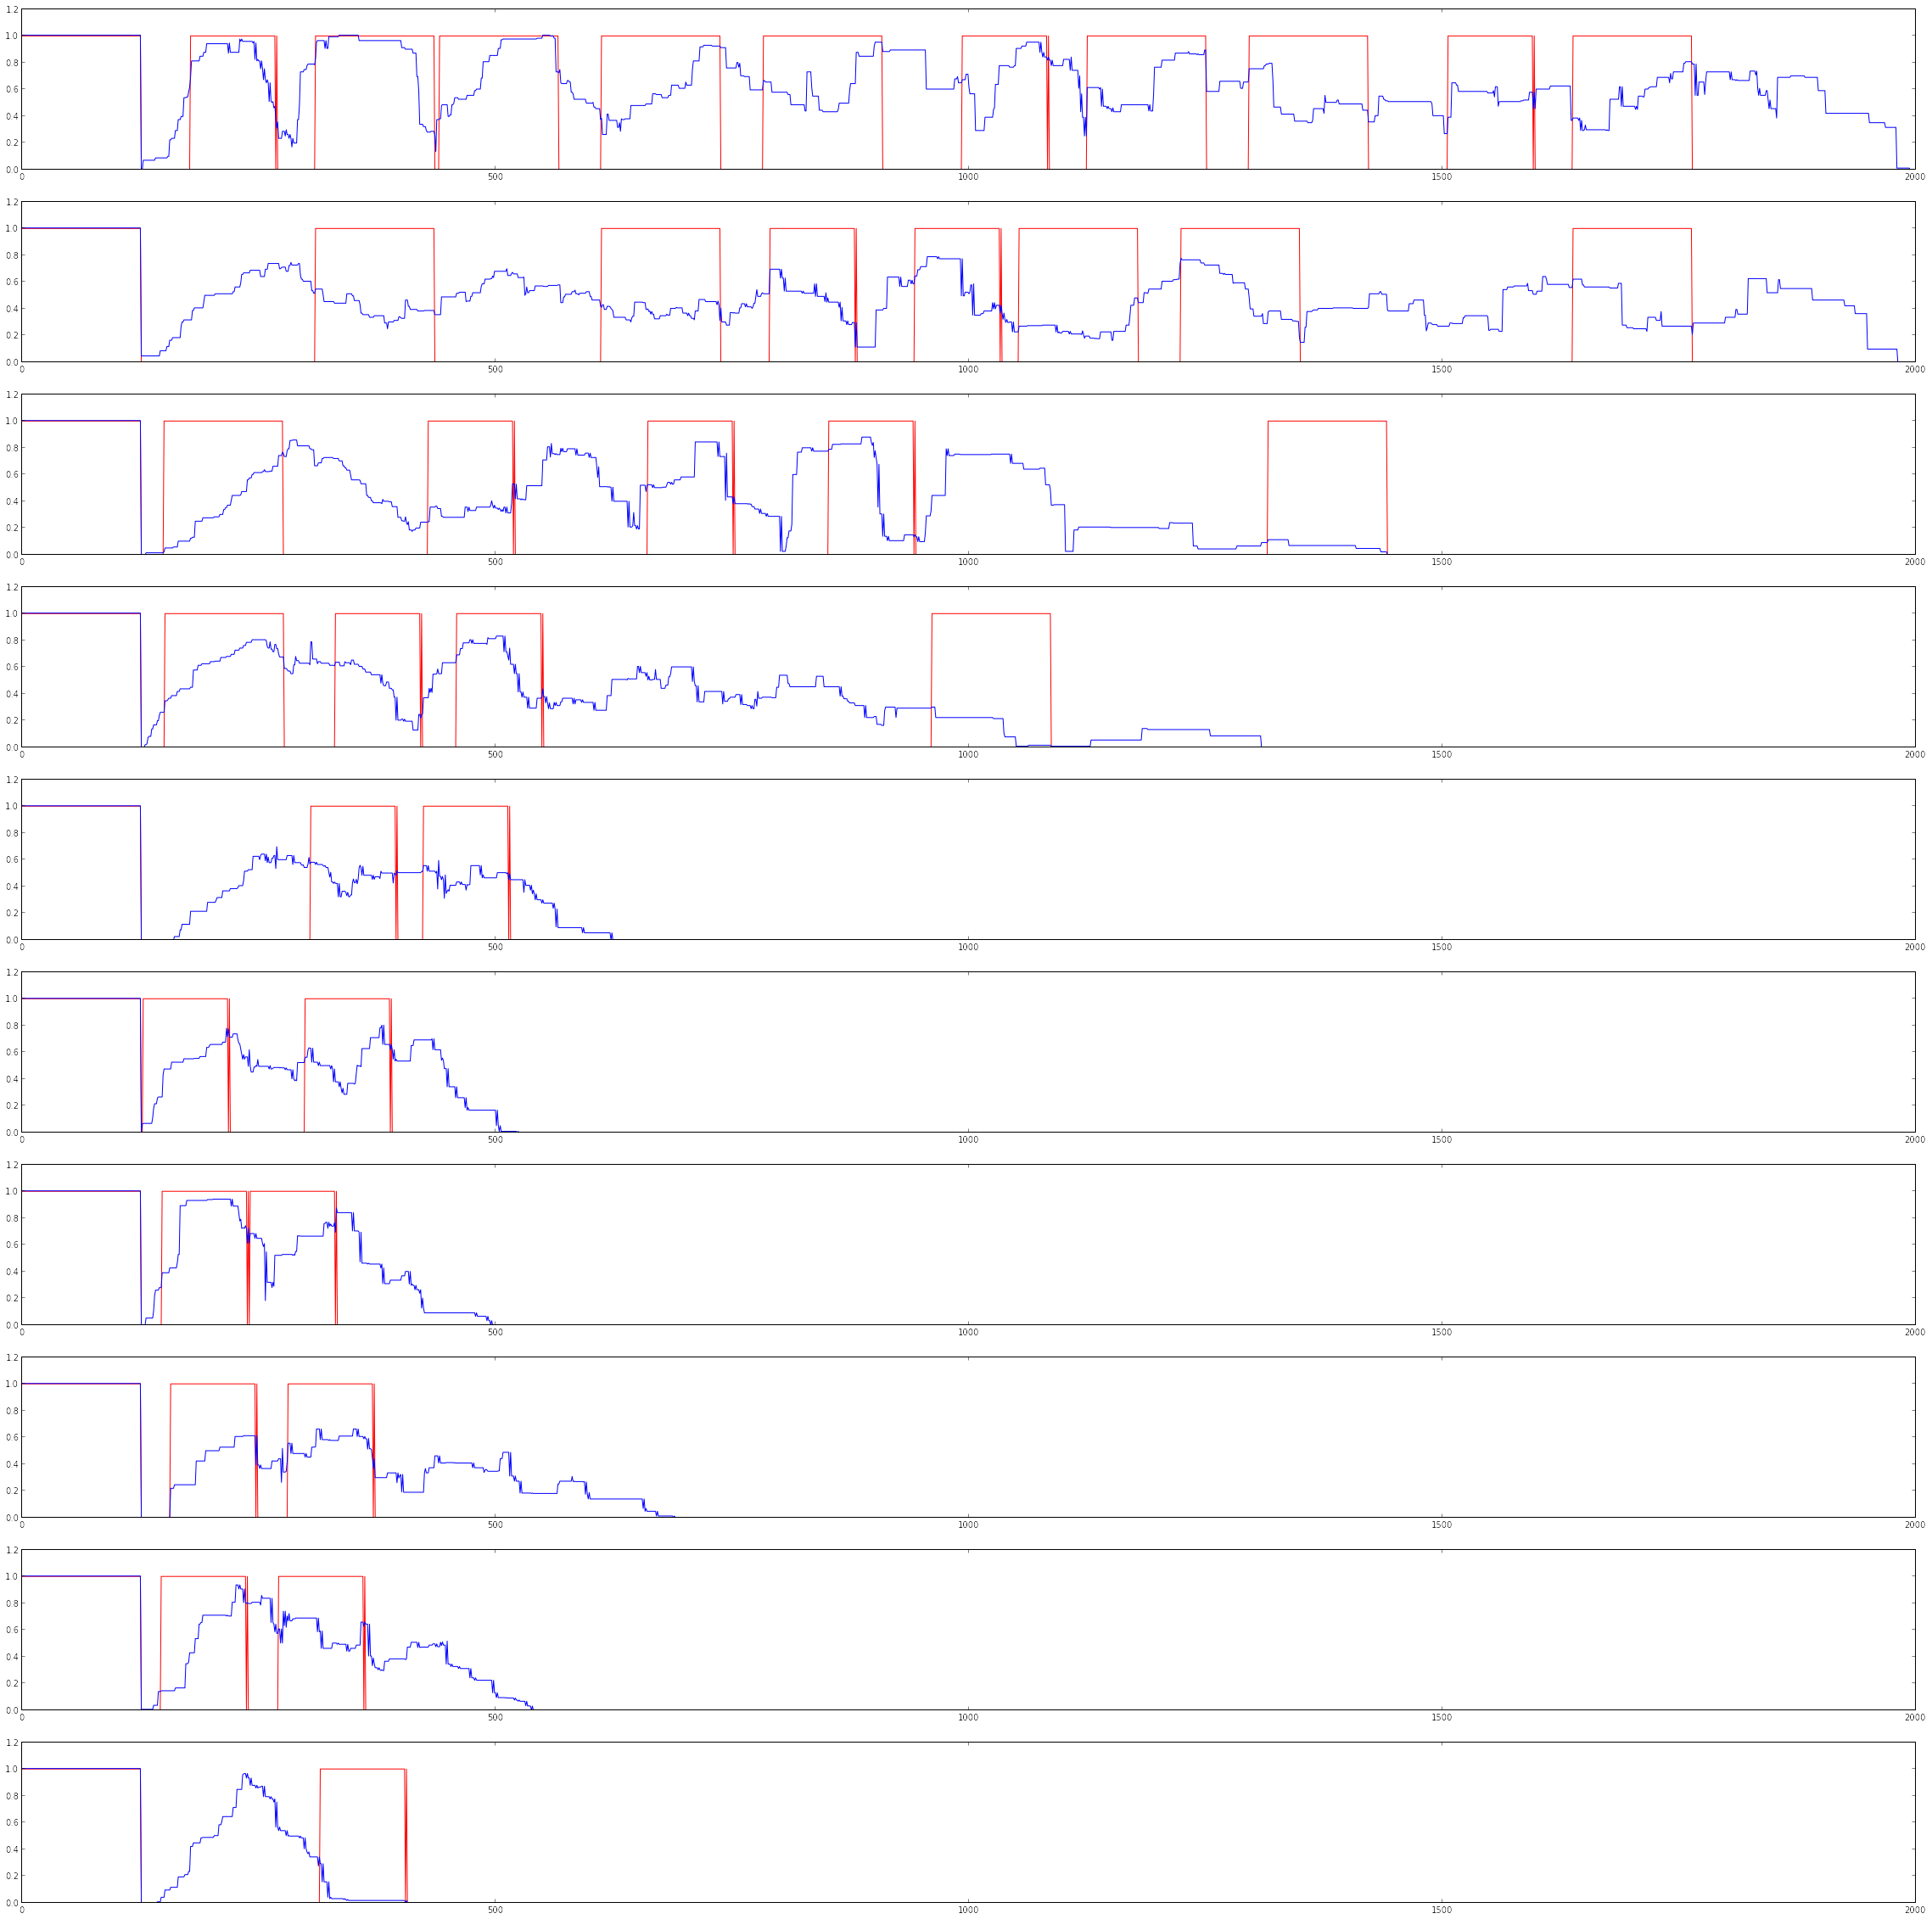

In [409]:
cycles = 10
gene = []
en = []
g = initializeGene(); gene.append(g)
gAv = []
for i in range(cycles):
    g = RNAP(g)
    gempty = np.sum(g == 0)
    en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    if gempty == (len(g) - OCT_LEN):
        print 'terminated early since only one left'
        en.extend([energy(g)]*(2*(cycles - (i + 1))+1)); gAv.extend([np.ceil(g/max(g))]*(2*(cycles - (i + 1))+1))
        break
    g, e, gA = MCMC(g, MIN_RATE)
    en.extend(e); gAv.append(gA/len(e))

fig = plt.figure(figsize=(4*cycles, 4*cycles))
ind = 0; pltInd = 0
while ind < 2*cycles:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()

In [410]:
# run several simulations varying transcription rate to gather statistics
runs = {}
cycles = 10
reps = 30
geneLen = 2000
pts = 10
minFreq = MIN_RATE
maxFreq = MAX_RATE

for trate in np.linspace(minFreq,maxFreq,pts):
    gene = np.zeros(geneLen); avgE = 0; nucR = 0; finE = 0; avgN = 0
    for rep in range(reps):
        en = []
        g = initializeGene()
        ncount = 0
        for i in range(cycles):
            g = RNAP(g);
            gempty = np.sum(g == 0)
            en.append(energy(g))
            if gempty == (len(g) - OCT_LEN):
                en.extend([energy(g)]*(2*(cycles - (i + 1))+1))
                ncount += 1.0*(cycles - (i + 1))*(len(detSpace(g)) - 1)/cycles
                break
            g, e, gA = MCMC(g, int(trate)); en.append(np.min(e))
            ncount += 1.0*(len(detSpace(g)) - 1)/cycles
        gene += np.ceil(g/max(g))/reps; avgE += np.mean(en)/reps; 
        nucR += 1.0*(len(detSpace(g)) - 1)/reps; finE += energy(g)/reps; avgN += ncount/reps
    runs[int(trate)] = [gene, avgE, finE, avgN, nucR]
    print reps, ' sims for MCMC iter ', int(trate), ' done'
print 'done'

30  sims for MCMC iter  750  done
30  sims for MCMC iter  1500  done
30  sims for MCMC iter  2250  done
30  sims for MCMC iter  3000  done
30  sims for MCMC iter  3750  done
30  sims for MCMC iter  4500  done
30  sims for MCMC iter  5250  done
30  sims for MCMC iter  6000  done
30  sims for MCMC iter  6750  done
30  sims for MCMC iter  7500  done
done


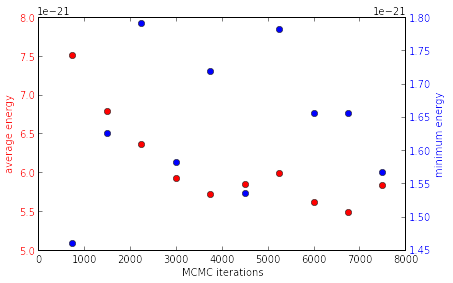

In [411]:
# plot energy
aen = []
men = []
trate = []
count = 0
for i in runs.keys():
    trate.append(i)
    aen.append(runs[i][1])
    men.append(runs[i][2])
    
order = np.argsort(trate)
trate = np.asarray(trate)[order]; men = np.asarray(men)[order]; aen = np.asarray(aen)[order]

fig, ax1 = plt.subplots()
minplot = 0
color = 'red'
ax1.set_xlabel('MCMC iterations')
ax1.set_ylabel('average energy', color=color)
ax1.plot(trate[minplot:], aen[minplot:], 'o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('minimum energy', color=color)  # we already handled the x-label with ax1
ax2.plot(trate[minplot:], men[minplot:], 'o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()

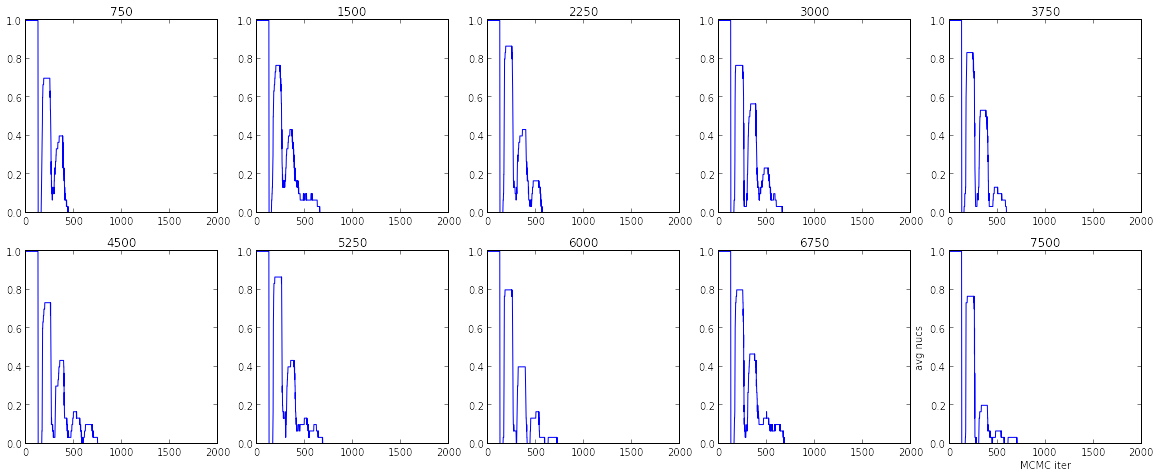

In [412]:
fig = plt.figure(figsize = (20,20))

pltInd = 0
keys = np.sort(runs.keys())
for i in keys:
    ax = fig.add_subplot(np.ceil(pts/2),np.floor(pts/2),pltInd+1)
    ax.plot(runs[i][0], '-')
    ax.set_title(i)
    pltInd += 1
    
plt.xlabel('MCMC iter'); plt.ylabel('avg nucs')
plt.show()

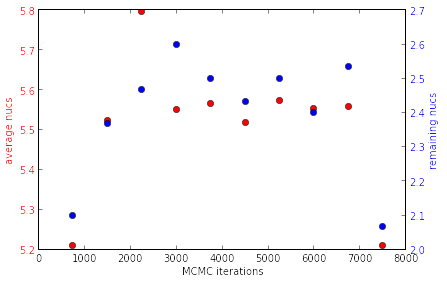

In [413]:
keys = np.sort(runs.keys())
y = []
y2 = []
for i in keys:
    y.append(runs[i][3])
    y2.append(runs[i][4])


order = np.argsort(trate)
trate = np.asarray(trate)[order]; y = np.asarray(y)[order]; y2 = np.asarray(y2)[order]

fig, ax1 = plt.subplots()
minplot = 0
color = 'red'
ax1.set_xlabel('MCMC iterations')
ax1.set_ylabel('average nucs', color=color)
ax1.plot(trate[minplot:], y[minplot:], 'o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('remaining nucs', color=color)  # we already handled the x-label with ax1
ax2.plot(trate[minplot:], y2[minplot:], 'o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()

plt.show()

### dimer replacement and nucleosome reassembly

In [414]:
def repair(g, prep, trate):
    spc = detSpace(g)
    nucs = np.sort(spc.keys()); nucs = np.asarray(nucs, int)
    hexes = []
    i = 1
    # replace nucleosomes
    while (i < len(spc)):
        nuc = np.asarray(np.linspace(0, len(g)-1, len(g))[g==nucs[i]], int)
        if (len(nuc) == HEX_LEN): # ensure that a hexasome is selected for
            rand = np.random.rand()
            if rand < prep and spc[nucs[i]] > (OCT_LEN-HEX_LEN)/2 and spc[nucs[i-1]] > (OCT_LEN-HEX_LEN)/2:
                # repair nuc
                g[nuc] = 0 
                # add nuc sides
                side = (OCT_LEN-HEX_LEN)/2
                nuc = np.asarray(np.linspace(min(nuc)-side, max(nuc)+side, OCT_LEN), int)
                g[nuc] = nucs[i]
        spc = detSpace(g)
        nucs = np.sort(spc.keys()); nucs = np.asarray(nucs, int)
        i += 1
    # add nucleosomes if space
    N = int(np.round(NUC_DENS*len(g)/(OCT_LEN + NUC_SPACE)))
    goal = np.round((N - (len(nucs) - 1))*1.0*trate/MAX_RATE)
    succ = 1
    ind = np.asarray(np.linspace(0, len(g)-1, len(g))[g==nucs[-1]], int)[-1] + NUC_SPACE # append after last nuc
    while ind + OCT_LEN < len(g) and succ < goal + 1:
        rand = np.random.rand()
        if rand < prep:
            g[ind:ind+OCT_LEN] = nucs[-1] + succ
            ind = ind + OCT_LEN + NUC_SPACE
            succ += 1
    return g

{0.0: 0, 1.0: 52, 2.0: 40, 3.0: 5, 4.0: 45, 5.0: 84, 6.0: 283, 8.0: 13, 9.0: 44, 10.0: 40, 11.0: 237}
{0.0: 0, 1.0: 35, 2.0: 23, 3.0: 5, 4.0: 45, 5.0: 67, 6.0: 266, 8.0: 13, 9.0: 27, 10.0: 23, 11.0: 44, 12.0: 67}


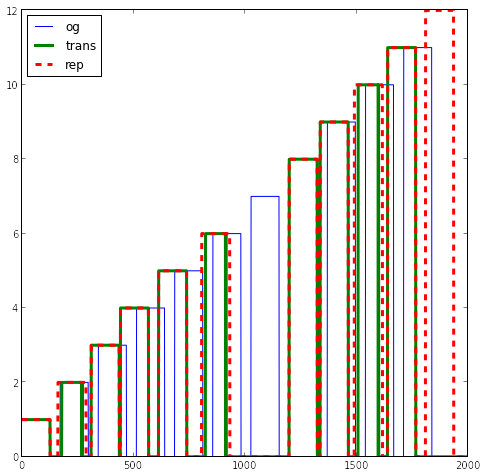

In [415]:
fig = plt.figure(figsize = (8,8))

g = initializeGene()
plt.plot(g, label = 'og', linewidth = 1)
g = RNAP(g)
plt.plot(g, label = 'trans', linewidth = 3)
print detSpace(g)
#g, e, ga = MCMC(g, 500)
g = repair(g, 1.0, MAX_RATE)
#g, e, ga = MCMC(g, 500)
plt.plot(g, '--', label = 'rep', linewidth = 3)
print detSpace(g)

plt.legend(loc = 'upper left')
plt.show()

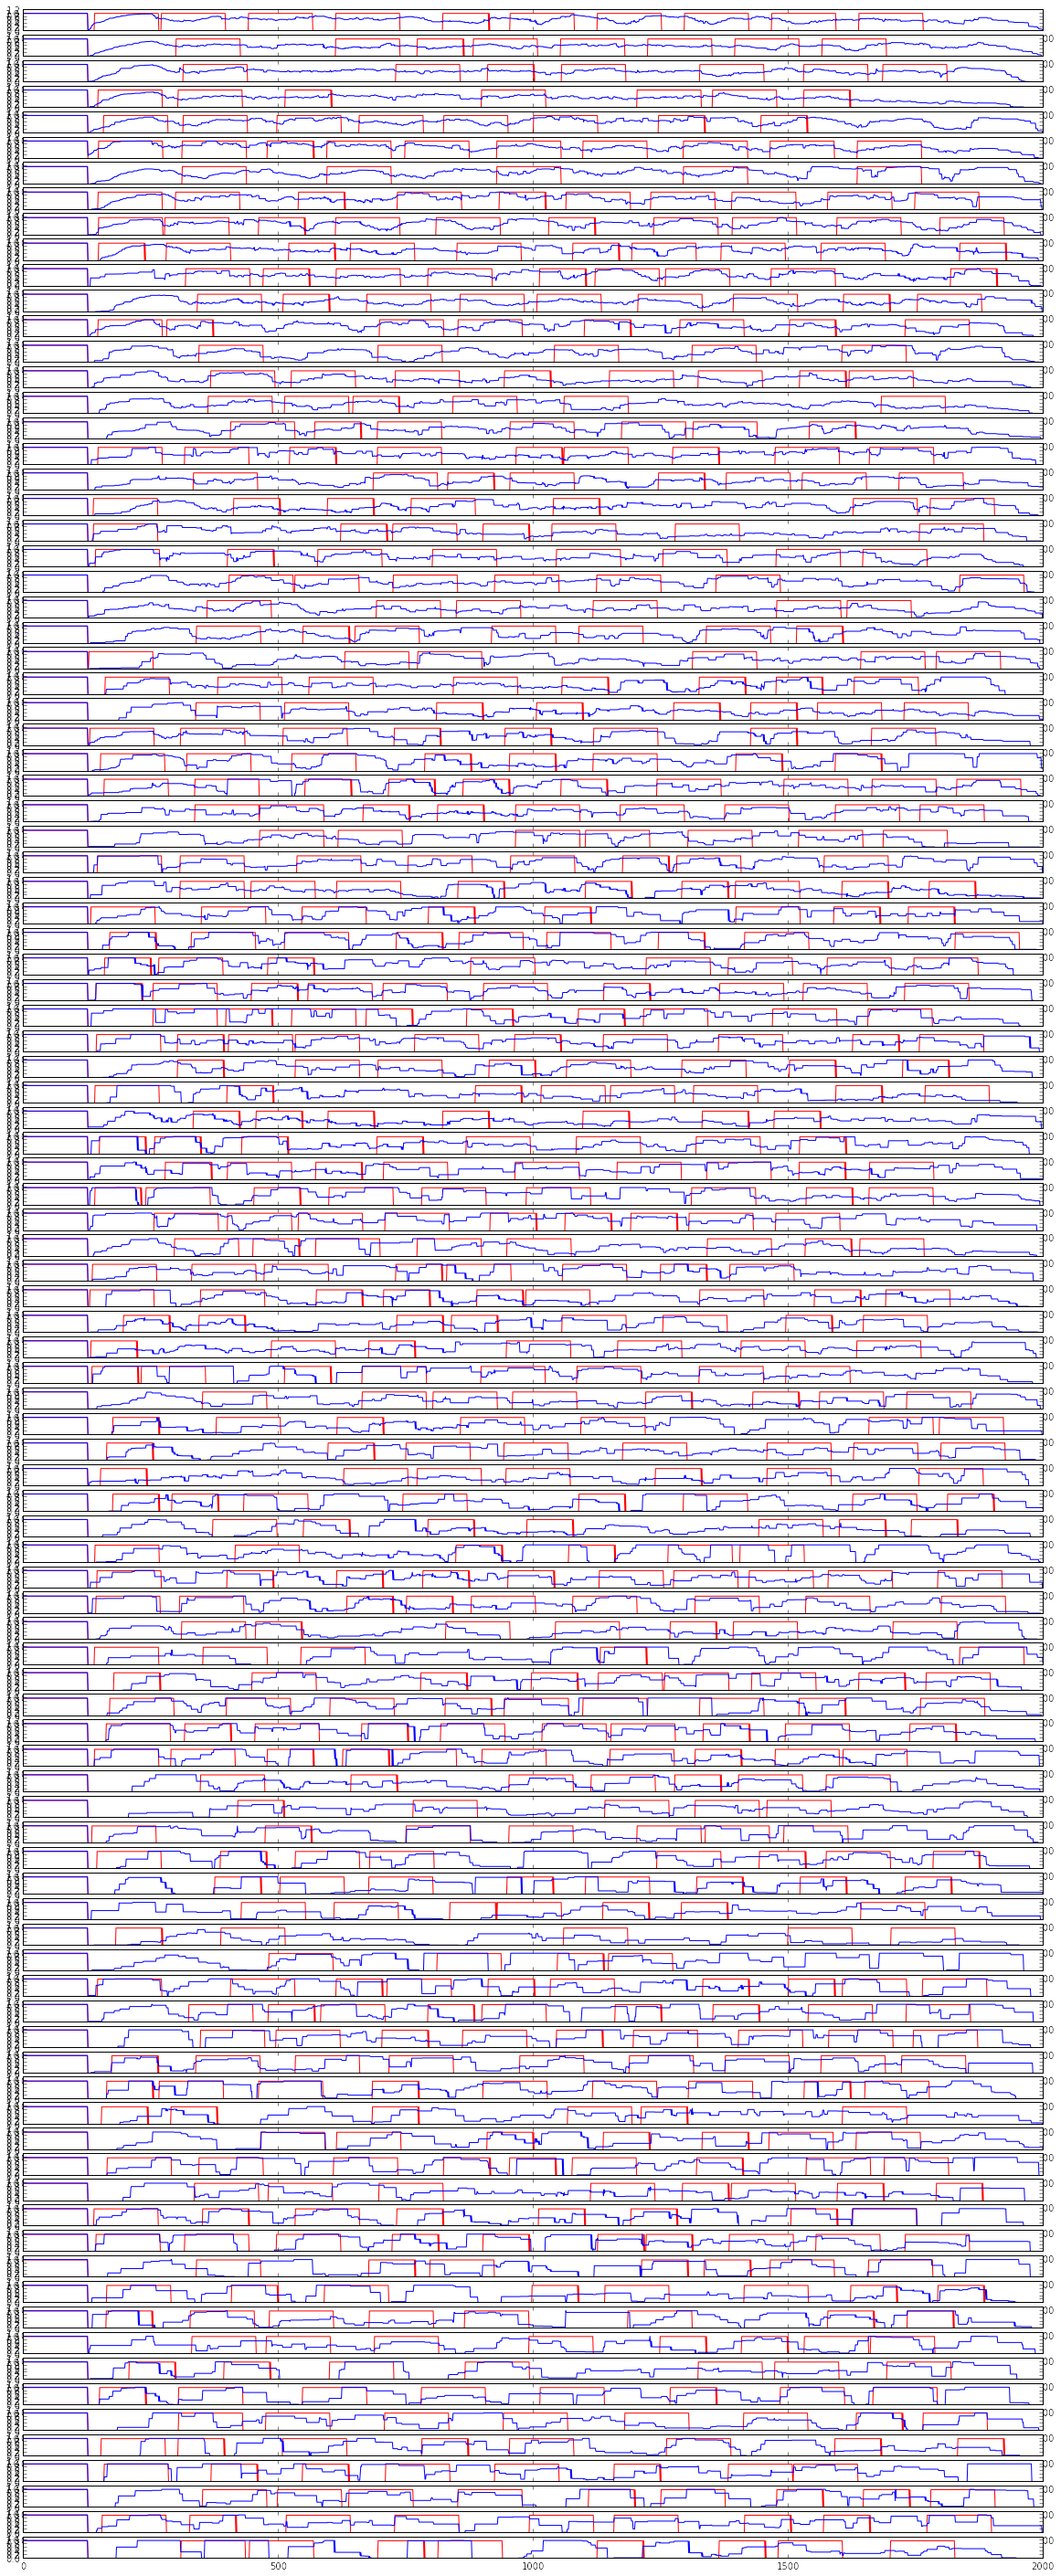

In [419]:
cycles = 100
gene = []
en = []
g = initializeGene()
gAv = []
for i in range(cycles):
    g = RNAP(g)
    gempty = np.sum(g == 0)
    en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    if gempty == (len(g) - OCT_LEN):
        print 'broke early on iter', i
        en.extend([energy(g)]*(4*(cycles - (i + 1))+3)); gAv.extend([np.ceil(g/max(g))]*(2*(cycles - (i + 1))+1))
        break
    g, e, gA = MCMC(g, MAX_RATE/2); en.extend(e)
    g = repair(g, 0.5, MAX_RATE); en.append(energy(g))
    g, e, gA = MCMC(g, MAX_RATE/2); en.extend(e); gAv.append(gA/len(e))

fig = plt.figure(figsize=(20, 50))
ind = 0; pltInd = 0
while ind < 2*cycles:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()

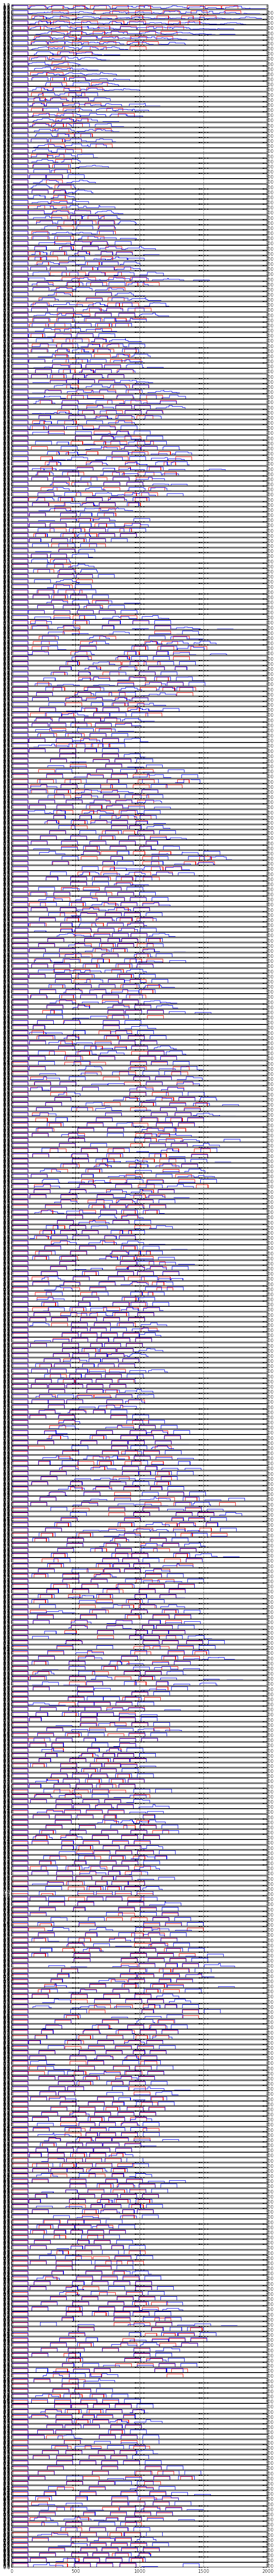

In [422]:
cycles = 500
gene = []
en = []
g = initializeGene()
gAv = []
for i in range(cycles):
    g = RNAP(g)
    gempty = np.sum(g == 0)
    en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    if gempty == (len(g) - OCT_LEN):
        print 'broke early on iter', i
        en.extend([energy(g)]*(4*(cycles - (i + 1))+3)); gAv.extend([np.ceil(g/max(g))]*(2*(cycles - (i + 1))+1))
        break
    g, e, gA = MCMC(g, MIN_RATE/2); en.extend(e)
    g = repair(g, 0.5, MIN_RATE); en.append(energy(g))
    g, e, gA = MCMC(g, MIN_RATE/2); en.extend(e); gAv.append(gA/len(e))

fig = plt.figure(figsize=(10, 100))
ind = 0; pltInd = 0
while ind < 2*cycles:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()

In [363]:
import time

# run several simulations varying transcription rate to gather statistics
runs2 = {}
cycles = 10
reps = 30
geneLen = 2000
pts = 10
minFreq = MIN_RATE
maxFreq = MAX_RATE

start = time.time()
counter = 0
for prep in np.linspace(0,1.0, pts):
    key1 = str(np.round(prep, 2))
    runs2[key1] = {}
    for trate in np.linspace(minFreq,maxFreq,pts):
        key2 = str(np.round(trate))
        runs2[key1][key2] = {}
        gene = np.zeros(geneLen); avgE = 0; nucR = 0; finE = 0; avgN = 0
        for rep in range(reps):
            en = []
            g = initializeGene()
            ncount = 0
            for i in range(cycles):
                g = RNAP(g);
                gempty = np.sum(g == 0)
                en.append(energy(g))
                if gempty == (len(g) - OCT_LEN):
                    en.extend([energy(g)]*(3*(cycles - (i + 1))+2))
                    ncount += 1.0*(cycles - (i + 1))*(len(detSpace(g)) - 1)/cycles
                    break
                g, e, gA = MCMC(g, int(1.0*trate/2)); temp = e
                g = repair(g, prep); en.append(energy(g))
                g, e, gA = MCMC(g, int(1.0*trate/2)); e.extend(temp); en.append(np.min(e))
                ncount += 1.0*(len(detSpace(g)) - 1)/cycles
            gene += np.ceil(g/max(g))/reps; avgE += np.mean(en)/reps; 
            nucR += 1.0*(len(detSpace(g)) - 1)/reps; finE += energy(g)/reps; avgN += ncount/reps
        runs2[key1][key2] = [gene, avgE, finE, avgN, nucR]
        counter += 1
        print '[', key1, ' ', key2, '] done (', counter, 'of', pts**2, ')'

stop = time.time()        

print 'done, in ', 1.0*(stop - start)/3600, 'hr'

TypeError: repair() takes exactly 3 arguments (2 given)

In [51]:
# save data if it looks good to avoid running again?
import csv
import os 

#os.chdir('./data')
os.getcwd()

w = csv.writer(open('2dtrials30acc.csv', 'w'))
for key, val in runs2.items():
    w.writerow([key, val])

### analysis

In [52]:
finEVec = np.zeros([pts, pts])
avgEVec = np.zeros([pts, pts])
posVec = [[0 for i in range(pts)] for j in range(pts)]
nucRVec = np.zeros([pts, pts])
nucAVec = np.zeros([pts, pts])
pkeys = np.sort(np.asarray(runs2.keys()))
tkeys = np.sort(np.asarray(runs2[pkeys[0]].keys()))
pVec = []
tVec = []
for i in range(len(pkeys)):
    for j in range(len(tkeys)):
        posVec[i][j] = runs2[pkeys[i]][tkeys[j]][0]
        avgEVec[i, j] = runs2[pkeys[i]][tkeys[j]][1]
        finEVec[i, j] = runs2[pkeys[i]][tkeys[j]][2]
        nucAVec[i, j] = runs2[pkeys[i]][tkeys[j]][3]
        nucRVec[i, j] = runs2[pkeys[i]][tkeys[j]][4]
        pVec.append(float(pkeys[i])); tVec.append(float(tkeys[j]))

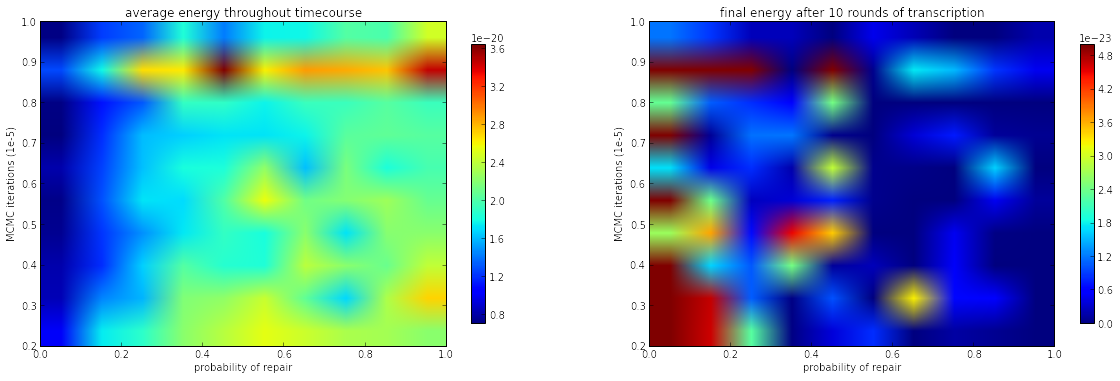

In [59]:
ucut = 5e-23

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(121)
surf = ax.imshow(avgEVec.T, cmap = 'jet', origin = 'lower',
                extent = (pVec[0], pVec[-1], tVec[0]/max(np.asarray(tVec)), tVec[-1]/max(np.asarray(tVec))))
fig.colorbar(surf, shrink = 0.5)
ax.set_title('average energy throughout timecourse')
ax.set_xlabel('probability of repair'); ax.set_ylabel('MCMC iterations (1e-5)')

ax = fig.add_subplot(122)
surf = ax.imshow(finEVec.T, cmap = 'jet', origin = 'lower', vmax = ucut,
                extent = (pVec[0], pVec[-1], tVec[0]/max(np.asarray(tVec)), tVec[-1]/max(np.asarray(tVec))))
fig.colorbar(surf, shrink = 0.5)
ax.set_title('final energy after 10 rounds of transcription')
ax.set_xlabel('probability of repair'); ax.set_ylabel('MCMC iterations (1e-5)')

plt.show()

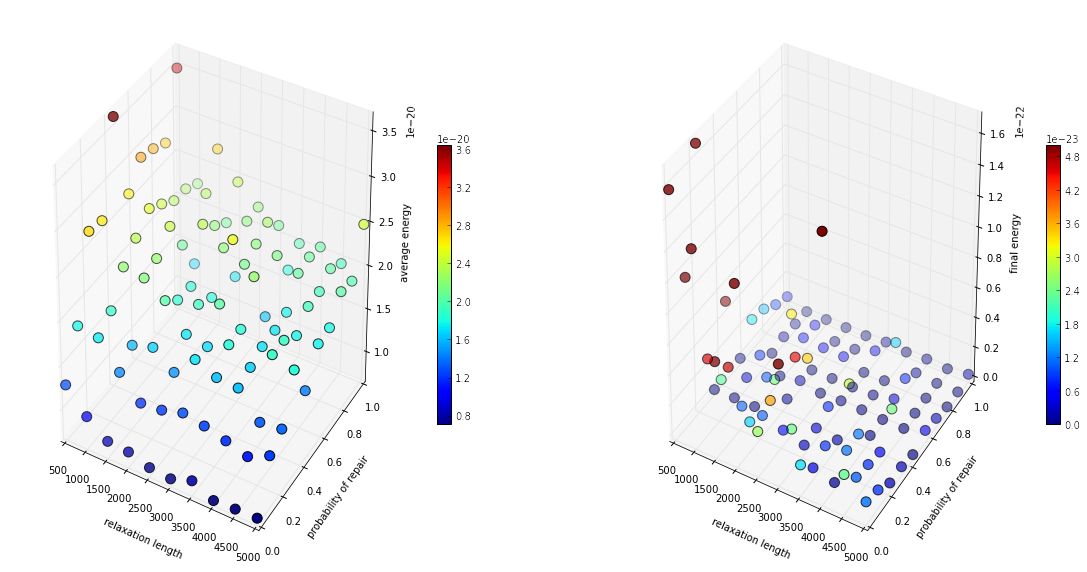

In [94]:
# 3D PLOTTING 
# of energy by prob and rate
fig = plt.figure(figsize = (20,10))

ax = fig.add_subplot(121,projection = '3d')

surf = ax.scatter(tVec, pVec, avgEVec, s= 100, c = avgEVec, cmap= 'jet')
#surf = ax.plot_surface(tVec, pVec, avgEVec, rstride = 1, cstride = 1, cmap= 'jet'); 
fig.colorbar(surf, shrink = 0.5)

ax.set_ylabel('probability of repair'); ax.set_xlabel('relaxation length'); ax.set_zlabel('average energy')

ax = fig.add_subplot(122,projection = '3d')

surf = ax.scatter(tVec, pVec, finEVec, s= 100, c = np.clip(finEVec, 0, ucut), cmap= 'jet')
#surf = ax.plot_surface(tVec, pVec, finEVec, cstride = 1, rstride = 1, cmap= 'jet'); 
fig.colorbar(surf, shrink = 0.5)

ax.set_ylabel('probability of repair'); ax.set_xlabel('relaxation length'); ax.set_zlabel('final energy')

plt.show()

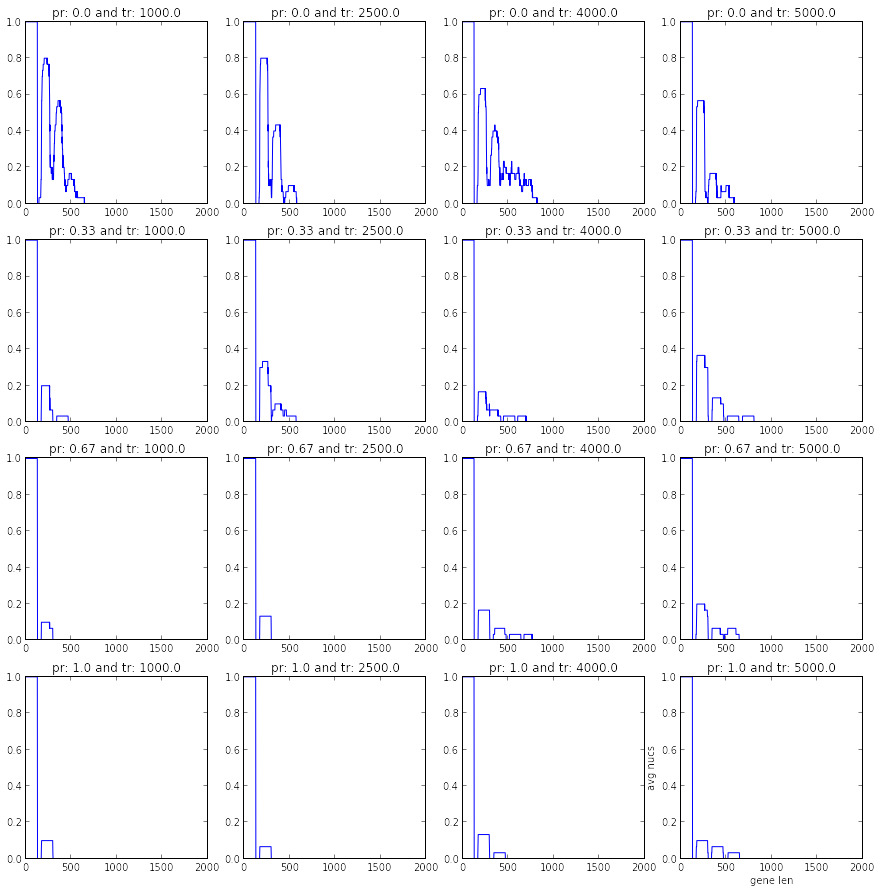

In [96]:
fig = plt.figure(figsize = (15,15))

pltInd = 0
for i in pkeys[0::3]:
    for j in np.sort(np.asarray(tkeys[0::3]), -1):
        ax = fig.add_subplot(4,4,pltInd+1)
        ax.plot(runs2[i][j][0], '-')
        ax.set_title(''.join(['pr: ', i, ' and tr: ', j]))
        pltInd += 1
    
plt.xlabel('gene len'); plt.ylabel('avg nucs')


plt.show()

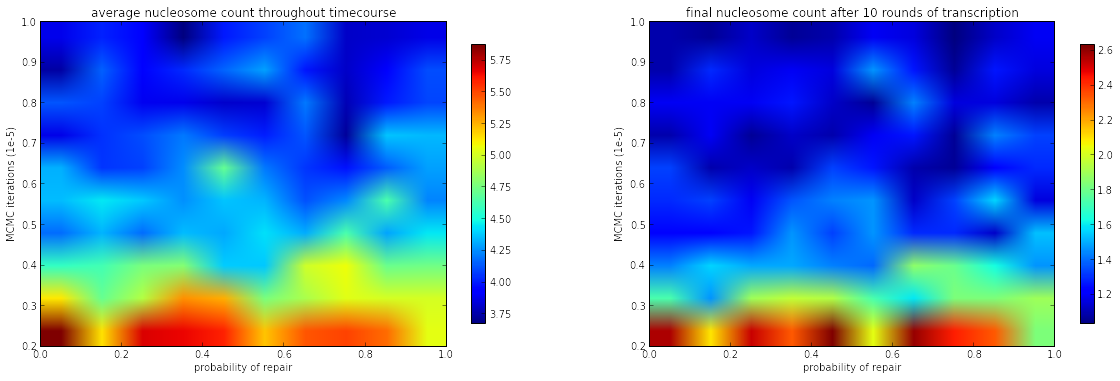

In [97]:
fig = plt.figure(figsize = (20,10))

ax = fig.add_subplot(121)
surf = ax.imshow(nucAVec, cmap = 'jet', origin = 'lower',
                 extent = (pVec[0], pVec[-1], tVec[0]/max(np.asarray(tVec)), tVec[-1]/max(np.asarray(tVec))))
fig.colorbar(surf, shrink = 0.5)
ax.set_title('average nucleosome count throughout timecourse')
ax.set_xlabel('probability of repair'); ax.set_ylabel('MCMC iterations (1e-5)')

ax = fig.add_subplot(122)
surf = ax.imshow(nucRVec, cmap = 'jet', origin = 'lower', 
                 extent = (pVec[0], pVec[-1], tVec[0]/max(np.asarray(tVec)), tVec[-1]/max(np.asarray(tVec))))
fig.colorbar(surf, shrink = 0.5)
ax.set_title('final nucleosome count after 10 rounds of transcription')
ax.set_xlabel('probability of repair'); ax.set_ylabel('MCMC iterations (1e-5)')

plt.show()

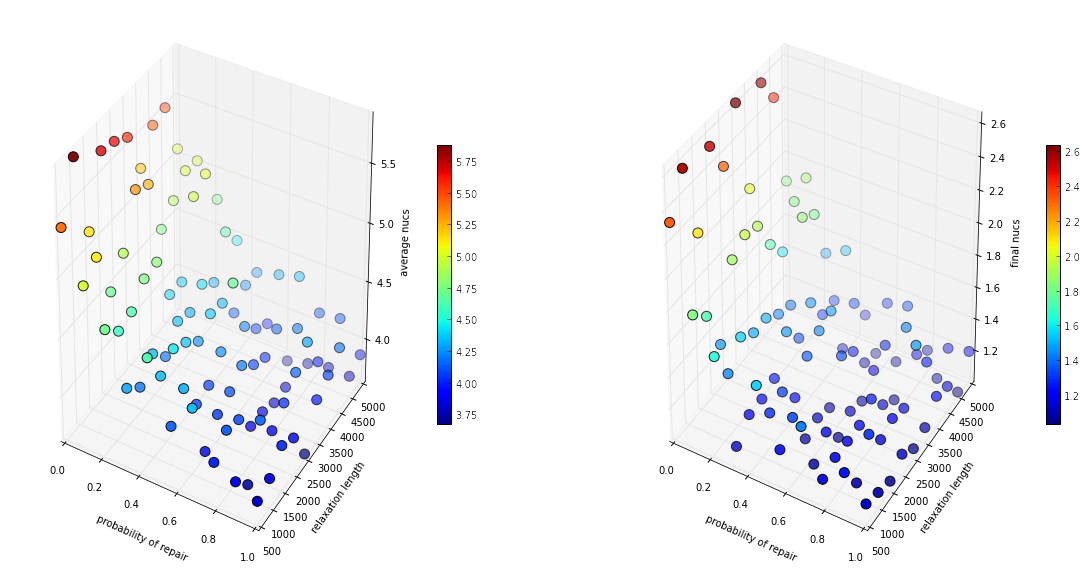

In [139]:
fig = plt.figure(figsize = (20,10))

ax = fig.add_subplot(121,projection = '3d')

surf = ax.scatter(pVec, tVec, nucAVec, s = 100, c = nucAVec, cmap = 'jet')
#surf = ax.plot_surface(pVec, tVec, nucAVec, cstride = 1, rstride = 1, cmap= 'jet')
fig.colorbar(surf, shrink = 0.5)

ax.set_xlabel('probability of repair'); ax.set_ylabel('relaxation length'); ax.set_zlabel('average nucs')

ax = fig.add_subplot(122,projection = '3d')

surf = ax.scatter(pVec, tVec, nucRVec, s = 100, c = nucRVec, cmap = 'jet')
#surf = ax.plot_surface(pVec, tVec, nucRVec, cstride = 1, rstride = 1, cmap= 'jet')
fig.colorbar(surf, shrink = 0.5)

ax.set_xlabel('probability of repair'); ax.set_ylabel('relaxation length'); ax.set_zlabel('final nucs')

info = nucRVec > 1.5

plt.show()

4000.0 0.0
1500.0 0.11



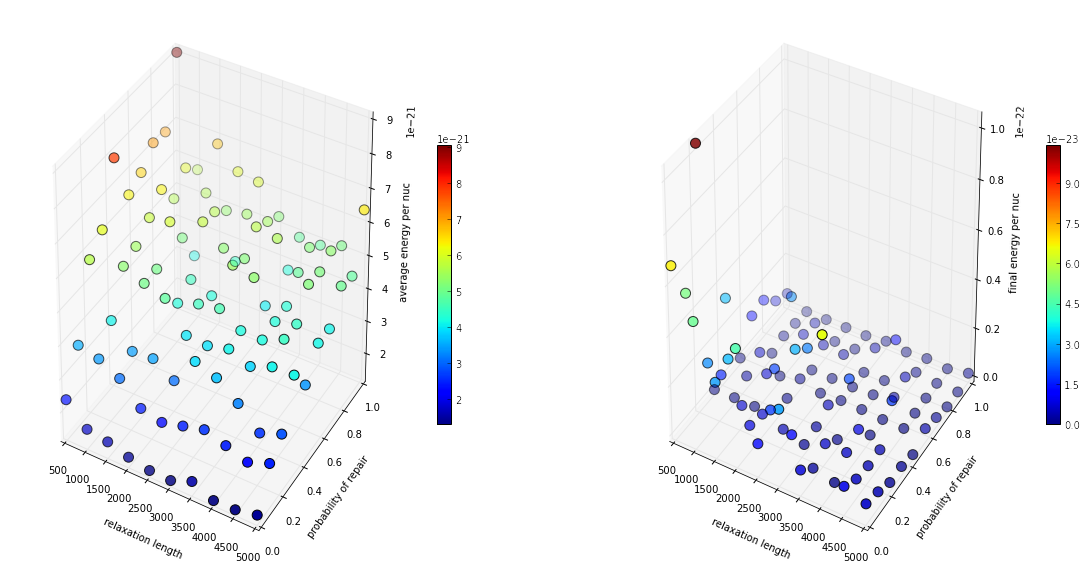

In [142]:
fig = plt.figure(figsize = (20,10))

ax = fig.add_subplot(121,projection = '3d')

surf = ax.scatter(tVec, pVec, avgEVec/nucAVec, s = 100, c = avgEVec/nucAVec, cmap = 'jet')
#surf = ax.plot_surface(tVec, pVec, avgEVec/nucAVec, cstride = 1, rstride = 1, cmap= 'jet');
fig.colorbar(surf, shrink = 0.5)

ax.set_ylabel('probability of repair'); ax.set_xlabel('relaxation length'); ax.set_zlabel('average energy per nuc')

ax = fig.add_subplot(122,projection = '3d')

surf = ax.scatter(tVec, pVec, finEVec/nucRVec, s = 100, c = finEVec/nucRVec, cmap = 'jet')
#surf = ax.plot_surface(tVec, pVec, finEVec/nucRVec, cstride = 1, rstride = 1, cmap= 'jet'); 
fig.colorbar(surf, shrink = 0.5)
ax.set_ylabel('probability of repair'); ax.set_xlabel('relaxation length'); ax.set_zlabel('final energy per nuc')

amin = np.argmin(avgEVec/nucAVec)
print tVec[amin], pVec[amin]

ap = np.zeros([pts, pts]) + (avgEVec/nucAVec)*np.asarray(info, int)
newmin = np.argmin(ap)
print tVec[newmin], pVec[newmin]
print 

plt.show()